In [ ]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import numpy as np

def download_dat_ki_dataset(output_csv="dat_binding_ki_correct.csv"):
    # Initialize ChEMBL clients
    activity_client = new_client.activity
    molecule_client = new_client.molecule

    # 1. Query DAT binding Ki data - using more specific search
    bioactivities = activity_client.filter(
        target_chembl_id="CHEMBL220",  # dopamine transporter
        type="Ki",                     # inhibition constant
        assay_type="B",                # binding assays only
        relation="=",                  # exact measurements
        target_organism="Homo sapiens" # human data
    ).only(
        "molecule_chembl_id",
        "standard_value", 
        "standard_units",
        "assay_description",
        "document_chembl_id",
        "target_chembl_id"  # Include this to verify
    )

    # Convert to DataFrame
    df_bio = pd.DataFrame.from_dict(bioactivities)
    print(f"Retrieved {len(df_bio)} bioactivity records")
    
    # Filter for DAT-specific assays only
    dat_keywords = ['dopamine transporter', 'DAT', 'dopamine uptake', 'dopamine reuptake']
    mask = df_bio['assay_description'].str.contains('|'.join(dat_keywords), case=False, na=False)
    df_bio = df_bio[mask]
    print(f"After DAT filtering: {len(df_bio)} records remain")

    # Rest of the code remains the same...
    # 2. Fetch molecular properties for each unique compound
    unique_ids = df_bio["molecule_chembl_id"].unique().tolist()
    molecules = molecule_client.filter(
        molecule_chembl_id__in=unique_ids
    ).only(
        "molecule_chembl_id",
        "canonical_smiles",
        "molecule_properties"
    )
    df_mol = pd.DataFrame.from_dict(molecules)
    print(f"Retrieved properties for {len(df_mol)} compounds")

    # 3. Merge bioactivity and molecule data
    df = pd.merge(df_bio, df_mol, on="molecule_chembl_id", how="inner")

    # 4. Convert Ki (nM) to pKi
    # First convert standard_value to numeric (handles string values from API)
    df["standard_value"] = pd.to_numeric(df["standard_value"], errors='coerce')
    
    # Remove any rows where standard_value couldn't be converted
    df = df.dropna(subset=['standard_value'])
    print(f"After numeric conversion: {len(df)} records remain")
    
    # standard_value is in nM; pKi = -log10(Ki * 1e-9)
    import numpy as np
    df["pKi"] = -np.log10(df["standard_value"] * 1e-9)

    # 5. Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Saved dataset to {output_csv}")

if __name__ == "__main__":
    download_dat_ki_dataset()


HTTPError: HTTP Error 404: Not Found

Loaded dataset with 684 records
Sample molecule_properties entry:
{'alogp': '7.65', 'aromatic_rings': 2, 'full_molformula': 'C40H66N4O4', 'full_mwt': '666.99', 'hba': 6, 'hbd': 0, 'heavy_atoms': 48, 'mw_freebase': '666.99', 'np_likeness_score': '-0.51', 'num_ro5_violations': 2, 'psa': '65.56', 'qed_weighted': '0.09', 'ro3_pass': 'N', 'rtb': 27}

Available property columns:
['alogp', 'aromatic_rings', 'full_molformula', 'full_mwt', 'hba', 'hbd', 'heavy_atoms', 'mw_freebase', 'np_likeness_score', 'num_ro5_violations', 'psa', 'qed_weighted', 'ro3_pass', 'rtb']

Using descriptor columns: ['mw_freebase', 'alogp', 'hba', 'hbd', 'psa', 'rtb', 'full_mwt', 'aromatic_rings', 'heavy_atoms']

Descriptor matrix shape: (684, 9)
Missing values per column:
mw_freebase       0
alogp             6
hba               6
hbd               6
psa               6
rtb               6
full_mwt          0
aromatic_rings    6
heavy_atoms       6
dtype: int64

After removing missing values: 678 records remain

PCA 

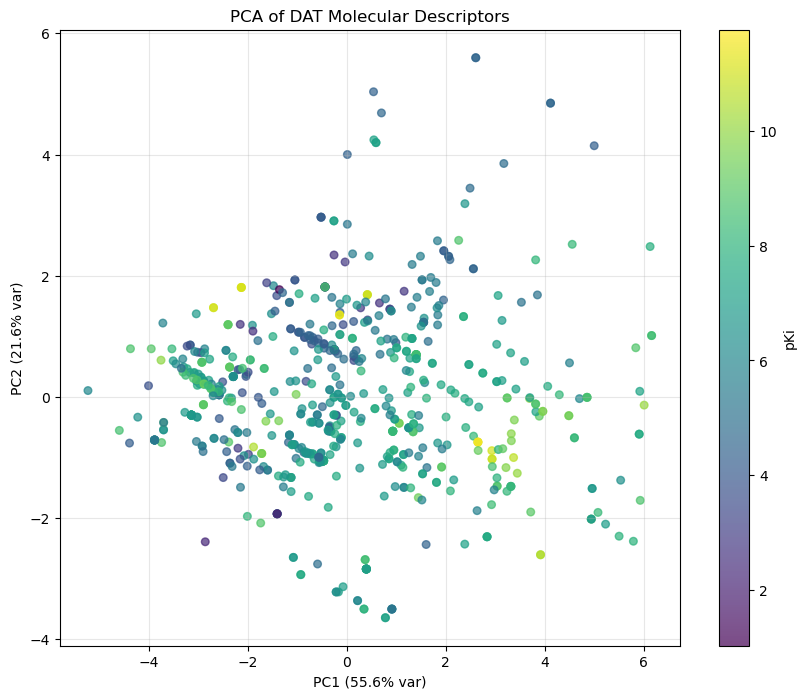


Dataset Summary:
Number of compounds: 678
Number of descriptors: 9
pKi range: 1.02 - 11.77
Mean pKi: 6.68 ± 1.81


In [3]:
# 1. Load the curated dataset
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ast
import numpy as np

df = pd.read_csv("dat_binding_ki.csv")
print(f"Loaded dataset with {len(df)} records")

# 2. Extract descriptor columns from molecule_properties
# The molecule_properties column contains string representations of dictionaries
print("Sample molecule_properties entry:")
print(df["molecule_properties"].iloc[0])

# Convert string representations to actual dictionaries
def parse_properties(prop_str):
    try:
        # Use ast.literal_eval to safely parse the string as a dictionary
        return ast.literal_eval(prop_str)
    except (ValueError, SyntaxError):
        return {}

df["parsed_properties"] = df["molecule_properties"].apply(parse_properties)

# Normalize the parsed properties into separate columns
props = pd.json_normalize(df["parsed_properties"])
print("\nAvailable property columns:")
print(props.columns.tolist())

# Select available descriptor columns (check which ones exist)
all_desc_cols = ["mw_freebase","alogp","hba","hbd","psa","rtb","full_mwt","aromatic_rings","heavy_atoms"]
available_desc_cols = [col for col in all_desc_cols if col in props.columns]
print(f"\nUsing descriptor columns: {available_desc_cols}")

# Convert to numeric and handle missing values
X = props[available_desc_cols].apply(pd.to_numeric, errors='coerce')
print(f"\nDescriptor matrix shape: {X.shape}")
print(f"Missing values per column:\n{X.isnull().sum()}")

# Remove rows with any missing descriptors
mask = ~X.isnull().any(axis=1)
X = X[mask]
y = df["pKi"][mask]
print(f"\nAfter removing missing values: {len(X)} records remain")

# 3. Standardize descriptors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

# 5. Plot
plt.figure(figsize=(10,8))
scatter = plt.scatter(pcs[:,0], pcs[:,1], c=y, cmap="viridis", s=30, alpha=0.7)
plt.colorbar(scatter, label="pKi")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of DAT Molecular Descriptors")
plt.grid(True, alpha=0.3)

# Show which descriptors contribute most to each PC
print("\nPCA Components (loadings):")
loadings_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=available_desc_cols
)
print(loadings_df)

plt.show()

# 6. Basic statistics
print(f"\nDataset Summary:")
print(f"Number of compounds: {len(X)}")
print(f"Number of descriptors: {len(available_desc_cols)}")
print(f"pKi range: {y.min():.2f} - {y.max():.2f}")
print(f"Mean pKi: {y.mean():.2f} ± {y.std():.2f}")
